In [1]:
import numpy as np
import pandas as pd
from tortreinador.utils.plot import plot_line_2
from tortreinador.utils.preprocessing import load_data
from tortreinador.train import TorchTrainer
from tortreinador.models.MDN import mdn, Mixture, NLLLoss
from tortreinador.utils.View import init_weights, split_weights
import torch
import torch.nn as nn
from tortreinador.utils.metrics import r2_score
import math
from sklearn.preprocessing import MinMaxScaler
import proplot as pplt
import matplotlib
import matplotlib.pyplot as plt
import joblib

In [2]:
file_path = 'D:\\Resource\\ML20210324.xlsx'

In [3]:
data = pd.read_excel(file_path)

In [4]:
data.head()

,Mass,Radius,H2O_mass_frac,Core_mass_frac,H2O_radial_frac,Mantle_radial_frac,Core_radial_frac,P_CMB,T_CMB
0,0.102235,0.575586,0.086587,0.001043,0.082640,0.843764,0.073596,22.4981,1813.07
1,7.917620,1.806100,0.071755,0.312248,0.088514,0.423073,0.488413,1115.6800,3716.50
2,4.096670,1.518440,0.040923,0.281079,0.053783,0.465935,0.480282,575.0740,3520.73
3,0.687502,0.883632,0.051069,0.543230,0.069849,0.275023,0.655128,73.6149,2094.55
4,0.810530,1.045990,0.094241,0.040204,0.089573,0.665036,0.245391,138.0260,2392.73


In [5]:
input_index = [0, 1]
output_index = [3, 4, 5, 6, 7, 8]

In [6]:
input_param = ['Mass', 'Radius']
output_param = ['Core_mass_frac', 'H2O_radial_frac', 'Mantle_radial_frac', 'Core_radial_frac', 'P_CMB', 'T_CMB']

In [7]:
t_loader, v_loader, t_x, t_y, m_x, m_y = load_data(data, input_param, output_param, batch_size=1024)

In [8]:
trainer = TorchTrainer(epoch=200)

Batch size: 512, Epoch:200, is GPU: True


In [9]:
model = mdn(len(input_param), len(output_param), 10, 512)
init_weights(model)
optimizer = torch.optim.Adam(split_weights(model), weight_decay=0.0001, lr=0.001)
criterion = NLLLoss()
pdf = Mixture()

In [10]:
t_l, v_l, val_r2, train_r2, mse = trainer.fit_for_MDN(t_loader, v_loader, criterion, model=model, mixture=pdf, model_save_path='D:\\Resource\\MDN\\rockyExoplanetV1\\', optim=optimizer, best_r2=0.8, warmup_epoch=10)

module.root_layer.0.weight : torch.Size([512, 2])
module.root_layer.0.bias : torch.Size([512])
module.root_layer.2.weight : torch.Size([512, 512])
module.root_layer.2.bias : torch.Size([512])
module.root_layer.4.weight : torch.Size([512, 512])
module.root_layer.4.bias : torch.Size([512])
module.pi.0.weight : torch.Size([512, 512])
module.pi.0.bias : torch.Size([512])
module.pi.2.weight : torch.Size([10, 512])
module.pi.2.bias : torch.Size([10])
module.mu.0.weight : torch.Size([512, 512])
module.mu.0.bias : torch.Size([512])
module.mu.2.weight : torch.Size([60, 512])
module.mu.2.bias : torch.Size([60])
module.sigma.0.weight : torch.Size([512, 512])
module.sigma.0.bias : torch.Size([512])
module.sigma.2.weight : torch.Size([60, 512])
module.sigma.2.bias : torch.Size([60])


  0%|          | 0/172 [00:00<?, ?batch/s]E:\anaconda\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch 200 Validating: 100%|██████████| 22/22 [00:01<00:00, 12.10batch/s, loss=-23.1244, loss_avg=-23.0242, mse=0.0306, r2=0.4689]


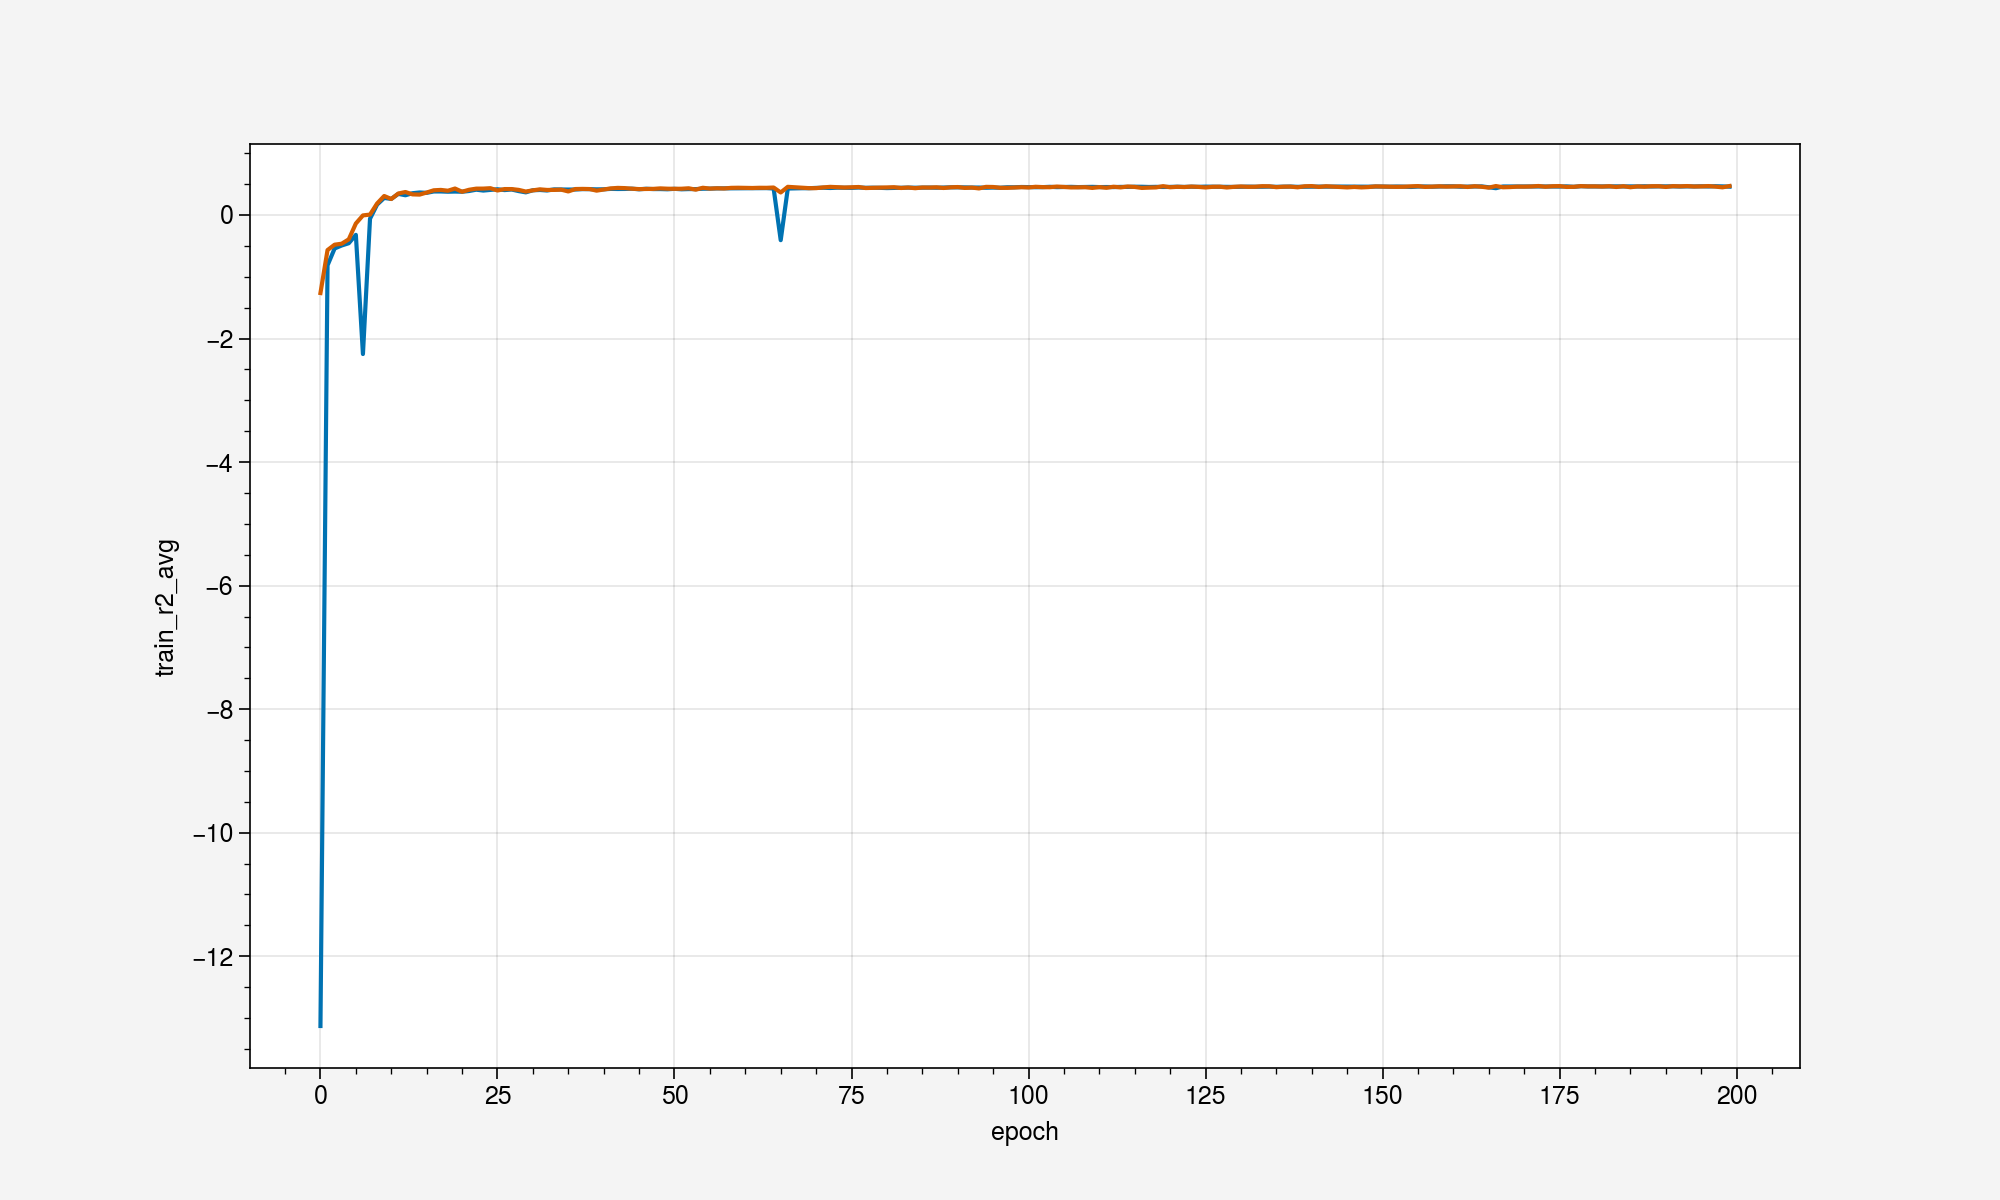

In [11]:
result_pd = pd.DataFrame()
result_pd['epoch'] = range(200)
result_pd['train_r2_avg'] = train_r2
result_pd['val_r2_avg'] = val_r2

plot_line_2(y_1='train_r2_avg', y_2='val_r2_avg', df=result_pd, fig_size=(10, 6), output_path=".\\imgs\\ROCKYEXOV1_MDN20240313_TrainValR2_2.png", dpi=300)

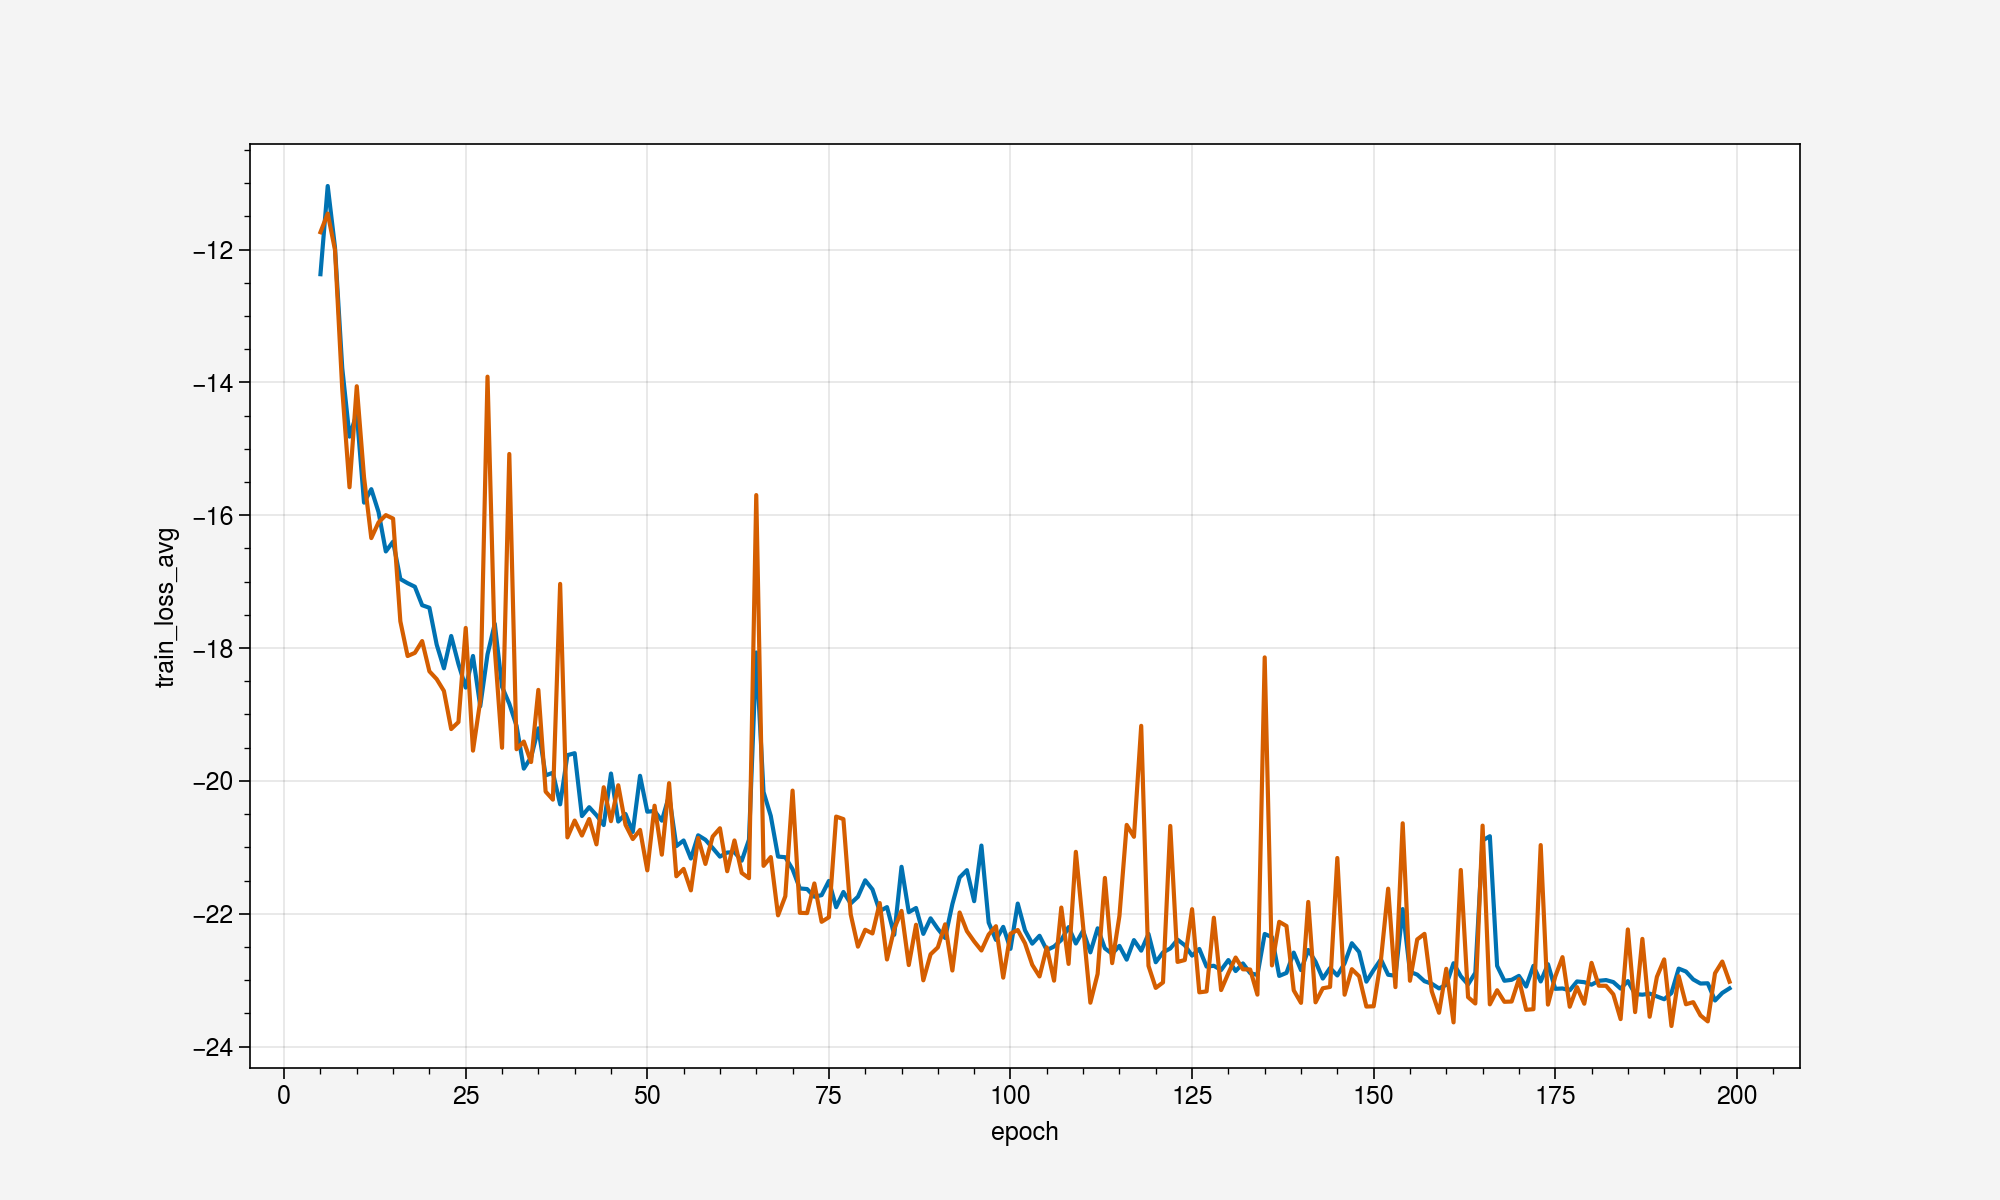

In [12]:
result_pd = pd.DataFrame()
result_pd['epoch'] = range(200)
result_pd['train_loss_avg'] = t_l
result_pd['validation_loss_avg'] = v_l

plot_line_2(y_1='train_loss_avg', y_2='validation_loss_avg', df=result_pd.iloc[5:, :], output_path=".\\imgs\\ROCKYEXOV1_MDN20240313_TrainValLoss_2.png")

In [13]:
r2_distance = np.abs((np.array(train_r2) - np.array(val_r2)).mean())
loss_distance = np.abs((np.array(t_l) - np.array(v_l)).mean())
loss_dis_df = pd.DataFrame(np.abs(np.array(t_l) - np.array(v_l))).iloc[10:, :]
max_dis_10 = loss_dis_df.sort_values(by=0, ascending=False).iloc[:10, :].sort_index()
dis_mean = max_dis_10.mean()